# Continuous Control - Report

## 1. Implementation Details
The implementation consists of files agent.py, model.py and ddpg_trainer.py found under the ddpg/ folder. The code is organized as follows:

`agent.py` contains code for the agent.

`model.py` contains the neural network code that is used by the agent.

`ddpg_trainer.py` contains code that is used to train the agent.
For information about the project and the environment can be found in the file `README.md`.

## 2. Algorithm
A code template implementing the Deep Deterministic Policy Gradient-algorithm from the Udacity course Deep Reinforcement Learning was used as the starting point of this project. This work extends the template by 

1. Collecting experiences from multiple agents. 
2. Using different neural networks for the Actor and Critic, including Batch Normalization.

I also initialized the local and target networks using the same weights (one set of weights for Actor networks and one for the Critic networks). This helped with the initial convergence on my test runs which still didn't stabilize well enough.

Finally, I turned off the Ornstein-Uhlenbeck noise for the actions, as it apparently made the algorithm unstable. I suspect the problem setup is so simple that the noise is not needed for effective exploration, but it only hinders performance after the networks have converged close to optimal weights. After removing the noise, the algorithm became stable and converged faster than during my test runs.

### Learning process
The algorithm uses two neural networks, the Actor that learns the optimal policy, and the Critic that learns the Q-function. The algorithm implements this as 4 neural networks, by having a local and a target network for both the Actor and Critic to stabilize learning.

The networks are training using collected (s,a,r,s') experience tuples from 20 agents, that are stored into a replay buffer. At regular intervals, we train the model by sampling tuples from the replay buffer and applying gradient based updates to the network weights. For more details see the further reading-section.

### Agent hyperparameters
| parameter                                     | value |
|-----------------------------------------------|-------|
| experience replay buffer size                 | 1e5   |
| minibatch size                                | 128   |
| gamma (discount factor)                       | 0.999 |
| tau (for soft update of target networks)      | 1e-3  |
| learning rate Actor                           | 2e-4  |
| learning rate Critic                          | 2e-4  |
| L2 weight decay (for optimizers)              | 0     |
| update_every (steps between networks updates) | 1     |
| update_times (number of consecutive/step)     | 1     |

### Neural network architecture

#### Actor
We used a neural network with 2 fully connected layers with ReLU activation and 128 hidden units. For the output layer we used tanh activation to scale the outputs to range (-1,1). We also applied Batch Normalization to the output of the first hidden layer.

#### Critic
Here we use again a neural network with 2 fully connected layers with ReLU activation and 128 hidden units. The first hidden layer takes the states as inputs. After applying non-linearity after after the 1st hidden layer, we concatenate the actions to the layer that feeds into the 2nd hidden layer. We applied Batch Normalization to the output of the first hidden layer (before we concatenate the actions, refer to the code in `model.py`).

We don't use activation function for the output layer as we are learning a Q-function.


### Further reading
[Continuous control with deep reinforcement learning (original paper on DDPG)](https://arxiv.org/pdf/1509.02971.pdf)

## 3. Training
Below we train the model for 400 iterations. We are forcing CPU computation in our implementation as we saw it trained faster for these small network architectures. If you want to run on a GPU instead, uncomment the line `torch.device("cuda:0" if torch.cuda.is_available() else "cpu")` in `agent.py`. 

If you want to watch a trained agent play, skip to part 4.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg.agent import Agent
from ddpg.ddpg_trainer import train_ddpg

In [2]:
# get handle to the environment
env = UnityEnvironment(file_name="Reacher_Windows_x86_64/Reacher.exe", no_graphics=True)

# environment metadata
state_size = 33
action_size = 4

# create the agent
agent = Agent(state_size, action_size, random_seed=35)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# Train the agent for 500 episodes
scores = train_ddpg(agent, env, n_episodes=400, max_t=2000, save=True)

Episode 100	Average Score: 28.61	Score: 36.77
Episode 104	Average Score: 30.13	Score: 37.64
Environment solved in 104 episodes!

Episode 200	Average Score: 37.13	Score: 37.48
Episode 300	Average Score: 37.88	Score: 38.68
Episode 400	Average Score: 38.15	Score: 36.09


In [4]:
env.close()

### 3.1 Plot of training rewards
We see that agent converged rather fast and that it was quite stable.

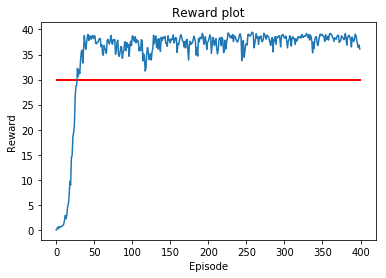

In [5]:
plt.plot(scores)
plt.hlines(y=30, xmin=0, xmax=400, linewidth=2, color='r')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward plot")
plt.show()

## 4. Watch the agent play (with pretrained model)

In [4]:
# imports
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg.agent import Agent

# environment metadata
state_size = 33
action_size = 4

In [8]:
# create the agent
agent = Agent(state_size, action_size, random_seed=1234)

# load saved model weights (load last checkpoint as it had best average results)
agent.actor_local.load_state_dict(torch.load("models/checkpoint_400_actor.pth"))
agent.critic_local.load_state_dict(torch.load("models/checkpoint_400_critic.pth"))

In [5]:
env.close()

In [8]:
# Watch agent play

# get handle to the environment (with graphics)
env = UnityEnvironment(file_name="Reacher_Windows_x86_64/Reacher.exe")

agent_scores = np.zeros(20) # initialize the scores
agent.reset()

# default brain
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        states = next_states
        agent_scores += rewards
        if np.any(dones):
            break

    
print("Score: {}".format(np.mean(agent_scores)))
# close the env
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 38.13349914764986


## 5. Future work
I think the implemented DDPG algorithm actually worked quite well after (big) initial struggles with the hyperparameter settings and tuning. Hence I don't have many ideas on how to improve this particular algorithm in this case. One could be implementing prioritized experience replay.

However, more interesting would be to try to solve the environment using some other learning algorithm such as [PPO](https://arxiv.org/pdf/1707.06347.pdf), [A3C](https://arxiv.org/pdf/1602.01783.pdf) or [D4PG](https://openreview.net/pdf?id=SyZipzbCb).